# Handling Missing Values -Setup
The dataset has null values for Temperature feature. 

This module implements various methods of imputation

In [ ]:
from google.colab import drive
import os
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

In [ ]:
drive.mount('/content/drive')
drivepath = "/content/drive/Shareddrives/DA224-O/mp_1/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv (drivepath+'SeoulBikeData_MP1.csv', index_col=0)

#print(df)

# Imputation Methods
Only 'Temperature(C) column has EMPTY values

As per requirement document, we need to use any of the below method to impute



*   Simple Imputation with mean and median
*   KNNImputer with neighbor size = 2, 4, 6
*   Linear Regression Models
**  Weather features
**  Time and Date features
**  Combination of these
*   KNeighbors Regressor Models 
**  Weather features
**  Time and Date features
**  Combination of these
*   bfill and ffill



# Feature Engineering
Among the Categorical values, it is a requirement to perform feature engineering for Time and Date column for Temperature Imputation.

In [ ]:
df['DateT'] = pd.to_datetime(df['Date'])
df['mnth'] = df["DateT"].dt.month
df['Sin_Hour'] = np.sin(2 * np.pi * df['Hour'] / max(df['Hour'])) 
df['Cos_Hour'] = np.cos(2 * np.pi * df['Hour'] / max(df['Hour']))
df['mnth_sin'] = np.sin((df.mnth-1)*(2.*np.pi/12))
df['mnth_cos'] = np.cos((df.mnth-1)*(2.*np.pi/12))
df = df.drop(["DateT", "mnth"], axis=1)

# ML Model for Rented Bike Count
Evaluation of Temperature Imputation

In [ ]:
def buildLRModel(X, y, option = 1):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

  if option == 1:
    num_pipeline = Pipeline([
                            ('imputer',SimpleImputer(strategy="mean")),
                            ('scaler',StandardScaler())
                            ])
  elif option == 2:
    num_pipeline = Pipeline([
                            ('imputer',SimpleImputer(strategy="median")),
                            ('scaler',StandardScaler())
                            ])
  elif option == 3:
    num_pipeline = Pipeline([
                            ('imputer',KNNImputer(n_neighbors=2)),
                            ('scaler',StandardScaler())
                            ])
  elif option == 4:
    num_pipeline = Pipeline([
                            ('imputer',KNNImputer(n_neighbors=4)),
                            ('scaler',StandardScaler())
                            ])
  elif option == 5:
    num_pipeline = Pipeline([
                            ('imputer',KNNImputer(n_neighbors=6)),
                            ('scaler',StandardScaler())
                            ])
  elif option == 6:
    num_pipeline = Pipeline([
                            ('scaler',StandardScaler())
                            ])
  elif option == 7:
    num_pipeline = Pipeline([
                            ('scaler',StandardScaler())
                            ])
  else:
    num_pipeline = Pipeline([
                            ('scaler',StandardScaler())
                            ])

  cat_pipeline = Pipeline([
                          ('encoder',OneHotEncoder())
                          ])

  cat_cols_idx = [0,1,10,11,12]
  X_train_num = X_train.copy()
  X_train_num.drop(X_train_num.columns[cat_cols_idx], axis = 1, inplace = True) 

  cat_cols = ['Date','Hour','Seasons','Holiday','Functioning Day']



  full_pipeline = ColumnTransformer([
                                    ('num',num_pipeline,list(X_train_num)),
                                    ('cat',cat_pipeline,cat_cols)
                                    ])

  X_train_prepared = full_pipeline.fit_transform(X_train)

  lin_reg = LinearRegression()

  lin_reg.fit(X_train_prepared,y_train)

  X_test_prepared = full_pipeline.transform(X_test)
  y_test_predict = lin_reg.predict(X_test_prepared)
  #mean_squared_error(y_test,y_test_predict,squared=False)
  MSE = mean_squared_error(y_test,y_test_predict,squared=False)
  R2 = r2_score(y_test,y_test_predict,multioutput='variance_weighted')
  #print("MSE = " +str(MSE)+ "\nR2 =", str(R2) )

  return MSE, R2

# Temperature Imputation Model

**Linear Regression**

We have tried 9 parameter combinations. This function accepts the param combination and returns model with accuracy matrices.



In [ ]:
def performLR(dfWithoutTemp, xcols):

  Xtem = dfWithoutTemp[xcols]
  ytem = dfWithoutTemp['Temperature(C)']
  X_trainT, X_testT, y_trainT, y_testT = train_test_split(Xtem, ytem, test_size= 0.2)

  #Perform Linear Regression
  lin_reg = LinearRegression()
  lin_reg.fit(X_trainT,y_trainT)

  y_test_predict = lin_reg.predict(X_testT)
  MSE = mean_squared_error(y_testT,y_test_predict,squared=False)
  R2 = r2_score(y_testT,y_test_predict,multioutput='variance_weighted')
  #print("** Imputation LR **\nMSE = " +str(MSE)+ "\nR2 =", str(R2) )
  return lin_reg,MSE,R2

# Temperature Imputation Model

## KNeighbors

* The function accepts the combination of parameter and perform KN

In [ ]:
#KNN
def performKNN(dfWithoutTemp, xcols):
  Xtem = dfWithoutTemp[xcols] 
  # Xtem = dfWithTemp[dfWithTemp.columns[[6,7, 9, 3, 1, 8]]] 
  ytem = dfWithoutTemp['Temperature(C)']
  X_trainT, X_testT, y_trainT, y_testT = train_test_split(Xtem, ytem, test_size= 0.2, random_state=42)

  #Perform Linear Regression
  lin_reg = KNeighborsRegressor()
  # lin_reg = LinearRegression()
  lin_reg.fit(X_trainT,y_trainT)

  y_test_predict = lin_reg.predict(X_testT)
  MSE = mean_squared_error(y_testT,y_test_predict,squared=False)
  R2 = r2_score(y_testT,y_test_predict,multioutput='variance_weighted')
  #print("** Imputation KNN **\nMSE = " +str(MSE)+ "\nR2 =", str(R2) )
  return lin_reg,MSE,R2



# Testing Bike Count Linear Regression Model 
**With all the Imputation Methods**

*  This code runs LR and KNR with all the 9 parameter combination. 
*  It creates R2 and MSE coefficients comparison plots.

In [ ]:
# Use only the rows with temperature value for building the model
dfWithoutTemp = df.loc[df['Temperature(C)'].notnull()]

# Keep the rows without Temperature value for prediction using the model created
dfPrediction = df.loc[df['Temperature(C)'].isna()]

paramCombination = [
                    ["Hour"], 
                    ["Sin_Hour", "Cos_Hour"], 
                    ["Sin_Hour", "Cos_Hour", "mnth_sin"], 
                    ["Dew point temperature(C)"], 
                    ["Dew point temperature(C)", "Solar Radiation (MJ/m2)"], 
                    ["Dew point temperature(C)", "Solar Radiation (MJ/m2)", "Humidity(%)"],
                    ["Dew point temperature(C)", "Solar Radiation (MJ/m2)", "Snowfall (cm)", "Humidity(%)", "Rainfall(mm)", "Hour"],
                    ["Dew point temperature(C)", "Solar Radiation (MJ/m2)", "Snowfall (cm)", "Humidity(%)", "Rainfall(mm)", "Sin_Hour", "Cos_Hour"],
                    ["Dew point temperature(C)", "Solar Radiation (MJ/m2)", "Snowfall (cm)", "Humidity(%)", "Rainfall(mm)", "Sin_Hour", "Cos_Hour", "mnth_sin"],]
LRMSE = []
LRR2 = []
KNNMSE = []
KNNR2 = []

ModelR2 = []
ModelRMSE = []

Name = ["Opt 1", "Opt 2", "Opt 3", "Opt 4", 'Opt 5', "Opt 6", "Opt 7", "Opt 8", "Opt 9"]

for i in range (1,6):
  X = df.drop(['Rented Bike Count'], axis=1)
  y = df['Rented Bike Count']
  MSE, R2 = buildLRModel(X, y, i)
  ModelR2.append(R2)
  ModelRMSE.append(MSE)

df_filled = df.bfill()
X = df_filled.drop(['Rented Bike Count'], axis=1)
y = df_filled['Rented Bike Count']
MSE, R2 = buildLRModel(X, y, i)
ModelR2.append(R2)
ModelRMSE.append(MSE)

df_filled = df.ffill()
X = df_filled.drop(['Rented Bike Count'], axis=1)
y = df_filled['Rented Bike Count']
MSE, R2 = buildLRModel(X, y, i)
ModelR2.append(R2)
ModelRMSE.append(MSE)

for xcols in paramCombination:
  lin_reg,MSE,R2 = performKNN(dfWithoutTemp, xcols)
  KNNMSE.append(MSE)
  KNNR2.append(R2)

  actualX = dfPrediction[xcols]
  actual_missing_temp_predict = lin_reg.predict(actualX)
  
  dfPrediction["Temperature(C)"] = actual_missing_temp_predict
  df_new = pd.concat([dfWithoutTemp, dfPrediction])
  X = df_new.drop(['Rented Bike Count'], axis=1)
  y = df_new['Rented Bike Count']

  MSE,R2 = buildLRModel(X, y, 0)
  ModelR2.append(R2)
  ModelRMSE.append(MSE)

for xcols in paramCombination:
  lin_reg,MSE,R2 = performLR(dfWithoutTemp, xcols)
  LRMSE.append(MSE)
  LRR2.append(R2)

  actualX = dfPrediction[xcols]
  actual_missing_temp_predict = lin_reg.predict(actualX)
  
  dfPrediction["Temperature(C)"] = actual_missing_temp_predict
  df_new = pd.concat([dfWithoutTemp, dfPrediction])
  X = df_new.drop(['Rented Bike Count'], axis=1)
  y = df_new['Rented Bike Count']

  MSE, R2 = buildLRModel(X, y, 0)
  ModelR2.append(R2)
  ModelRMSE.append(MSE)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# Accuracy of Imputation 
RMSE and R2 plots of Linear Regression and KNeighbors Regressor models



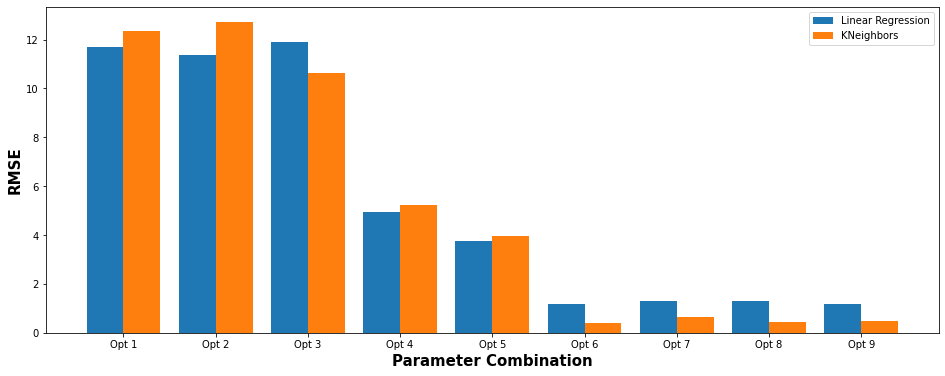

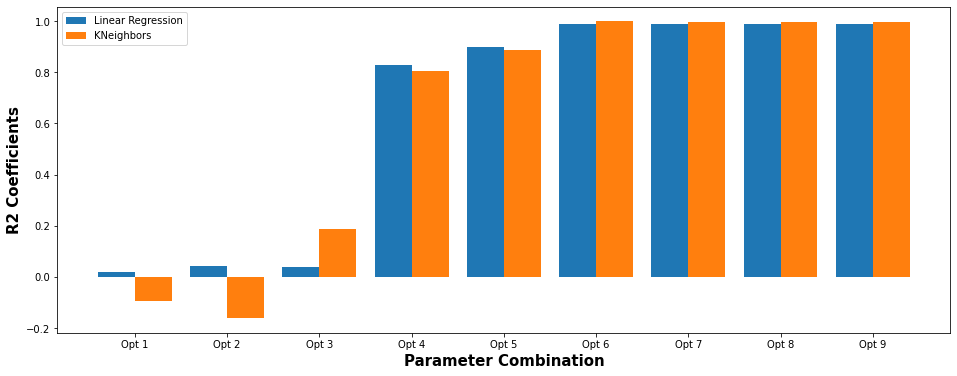

In [ ]:
fig = plt.subplots(figsize =(16, 6))
# Horizontal Bar Plot
#plt.bar(Name, LRMSE)
br1 = np.arange(len(LRMSE))
br2 = [x + 0.4 for x in br1]
plt.xlabel('Parameter Combination', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE', fontweight ='bold', fontsize = 15)
plt.bar(br1, LRMSE, width = 0.4, label="Linear Regression")
plt.bar(br2, KNNMSE, width = 0.4, label="KNeighbors")
plt.xticks([r + 0.2 for r in range(len(LRMSE))],
        Name)
plt.legend()
plt.savefig('RMSE.png', dpi=300, bbox_inches='tight')
plt.show()


fig = plt.subplots(figsize =(16, 6))
plt.xlabel('Parameter Combination', fontweight ='bold', fontsize = 15)
plt.ylabel('R2 Coefficients', fontweight ='bold', fontsize = 15)
plt.bar(br1, LRR2, width = 0.4, label="Linear Regression")
plt.bar(br2, KNNR2, width = 0.4, label="KNeighbors")
plt.xticks([r + 0.2 for r in range(len(LRMSE))],
        Name)
plt.legend()
plt.savefig('R2.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:

res = "\n".join("{} {}".format(x, y) for x, y in zip(Name, paramCombination))
print(res)

Opt 1 ['Hour']
Opt 2 ['Sin_Hour', 'Cos_Hour']
Opt 3 ['Sin_Hour', 'Cos_Hour', 'mnth_sin']
Opt 4 ['Dew point temperature(C)']
Opt 5 ['Dew point temperature(C)', 'Solar Radiation (MJ/m2)']
Opt 6 ['Dew point temperature(C)', 'Solar Radiation (MJ/m2)', 'Humidity(%)']
Opt 7 ['Dew point temperature(C)', 'Solar Radiation (MJ/m2)', 'Snowfall (cm)', 'Humidity(%)', 'Rainfall(mm)', 'Hour']
Opt 8 ['Dew point temperature(C)', 'Solar Radiation (MJ/m2)', 'Snowfall (cm)', 'Humidity(%)', 'Rainfall(mm)', 'Sin_Hour', 'Cos_Hour']
Opt 9 ['Dew point temperature(C)', 'Solar Radiation (MJ/m2)', 'Snowfall (cm)', 'Humidity(%)', 'Rainfall(mm)', 'Sin_Hour', 'Cos_Hour', 'mnth_sin']


# Evaluation of Bike Rent Model 
Applying the Temperature Imputation methods in LR model for Bike Cout

[324.93142843009906, 333.19700675158685, 324.6188445773173, 328.8550822222718, 333.98818858284903, 325.6051847603719, 323.96079895863045, 324.8693314783893, 311.2555846112916, 327.13057256376123, 333.4674019716923, 334.45936005372175, 322.57366901294995, 329.06276083419755, 321.7255386212823, 318.5088080487021, 340.78837847447863, 332.22488722368786, 335.2173599859161, 316.3028516783545, 321.73847410211187, 328.3116023449995, 326.81905949849494, 322.23916561348756, 330.70393203055744]
[0.745934640716795, 0.720298379379817, 0.7358080849564033, 0.7406881871263636, 0.7517885217308906, 0.7430581819718736, 0.742633275050357, 0.7395991704739517, 0.7478148264384423, 0.7358671965124486, 0.742197252554274, 0.7393992173152747, 0.7502265325018702, 0.7547044062861245, 0.7425923663561713, 0.7381421688319147, 0.7388103124020852, 0.7574572479870678, 0.7386555740870926, 0.7546077142578509, 0.7431674807269202, 0.739259621270902, 0.7468987596355755, 0.74647150703261, 0.7470139956926111]


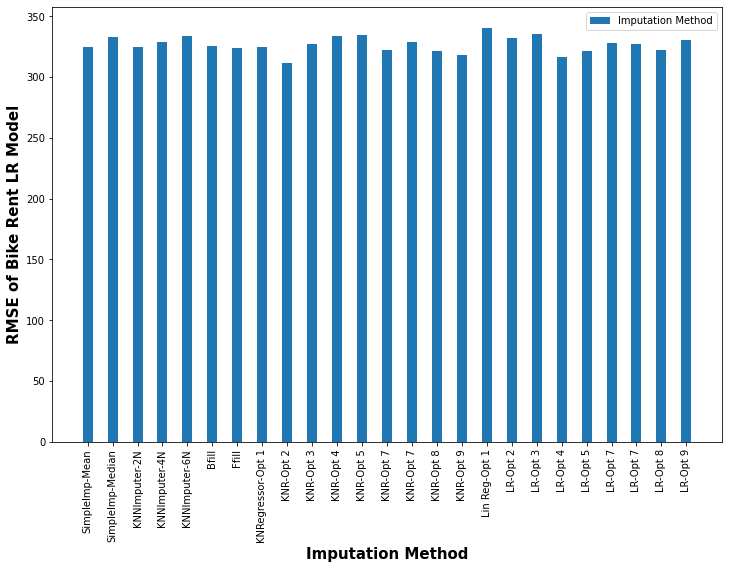

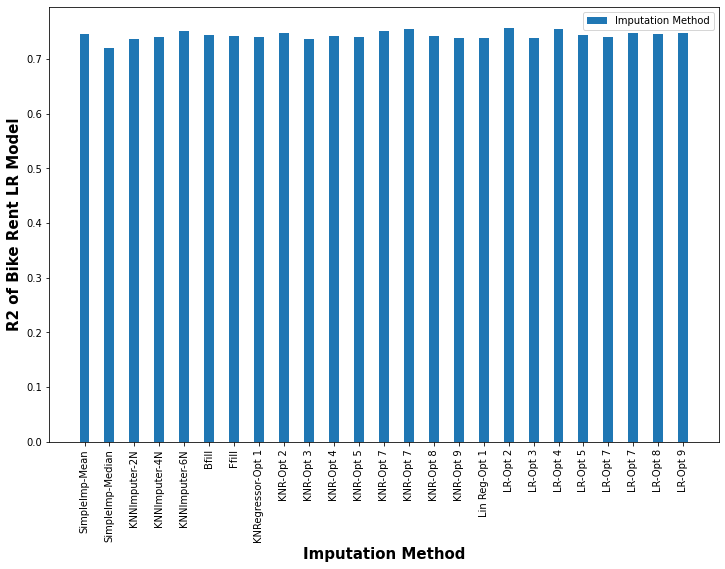

In [ ]:
print (ModelRMSE)
print (ModelR2)
Name = ["SimpleImp-Mean", "SimpleImp-Median", "KNNImputer-2N", "KNNImputer-4N", "KNNImputer-6N", "Bfill", "Ffill",
        "KNRegressor-Opt 1", "KNR-Opt 2", "KNR-Opt 3", "KNR-Opt 4", "KNR-Opt 5", "KNR-Opt 7",
        "KNR-Opt 7", "KNR-Opt 8","KNR-Opt 9",
        "Lin Reg-Opt 1", "LR-Opt 2", "LR-Opt 3", "LR-Opt 4", "LR-Opt 5", "LR-Opt 7",
        "LR-Opt 7", "LR-Opt 8","LR-Opt 9"]

fig = plt.subplots(figsize =(12, 8))
# Horizontal Bar Plot
#plt.bar(Name, LRMSE)
br1 = np.arange(len(ModelRMSE))
br2 = [x + 0.4 for x in br1]
plt.xlabel('Imputation Method', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE of Bike Rent LR Model', fontweight ='bold', fontsize = 15)
plt.bar(br1, ModelRMSE, width = 0.4, label="Imputation Method")
plt.xticks([r for r in range(len(ModelR2))],
        Name)
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig = plt.subplots(figsize =(12, 8))
plt.xlabel('Imputation Method', fontweight ='bold', fontsize = 15)
plt.ylabel('R2 of Bike Rent LR Model', fontweight ='bold', fontsize = 15)
plt.bar(br1, ModelR2, width = 0.4, label="Imputation Method")
plt.xticks([r for r in range(len(ModelR2))],
        Name)
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Conclusion


*   Evaluated various Imputation methods
*   Tested Bike Rent Count LR model with various imputation method.
*   KNR model with Opt-8 Paramters gives the best RMSE and R2 for Bike Rental Model.
*   **Hence, we choose the model as our Temperature Imputation method for further evaluations.**

